In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math

# Homework 1

## (A) Choosing an example image


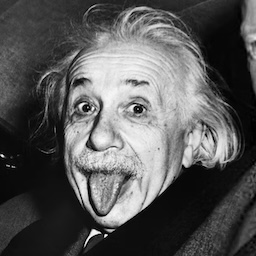

In [2]:
image = Image.open("resources/einstein.jpeg")

# Convert to grayscale
grey_avg_array = (np.sum(image, axis = -1, keepdims = False) / 3)
grey_avg_array = grey_avg_array.astype(np.uint8)
image = Image.fromarray(grey_avg_array, "L")

image

## (B) Simple center-surround receptive field

Filter the photo by the center-surround receptive fields of the retinal ganglion cells. You can start with the practice of the toy models of the center-surround receptive fields that we used in the tutorial. These toy models have receptive field’s shape described by $K(x, y)$ as a function of horizontal and vertical displacement $x$ and $y$ from the center of the receptive field. 

$$
K(x, y) = \begin{cases}
      1 & \text{ when }\ |x| < L/2 \text{, } |y| < L/2\\
      -v & \text{ when }\ |x| \geq L/2 \text{, } |y| \geq L/2
    \end{cases}
$$

Give a couple of examples using different parameters $L$ and $v$. Plot out the responses of the ganglion cells as an image to show the outcomes.

In [3]:
def square_filter(v, l):
    filter = np.ones(shape = (l, l)) * v

    # Estimate the center of the receptive field
    center = int(l / 2)

    # Estimate the width of the excitatory receptive field area
    width = int(l / 4)
    if width == 0: width = 1

    for i in range(filter.shape[0]):
        for j in range(filter.shape[1]):
            if np.abs(i - center) < width and np.abs(j - center) < width:
                filter[i, j] = 1

    return filter

In [4]:
def apply_filter(image, filter):
    return convolve2d(image, filter)

In [5]:
def plot_filter_and_image(filter, image):
    plt.subplot(1, 2, 1)
    plt.imshow(filter, cmap = "gray")
    plt.colorbar(fraction = 0.046, pad = 0.04)

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap = "gray")
    plt.colorbar(fraction = 0.046, pad = 0.04)

    plt.tight_layout()
    plt.show()

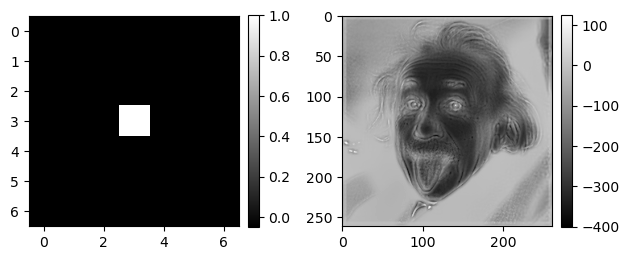

In [6]:
filter = square_filter(v = -0.05, l = 7)
plot_filter_and_image(filter, apply_filter(image, filter))

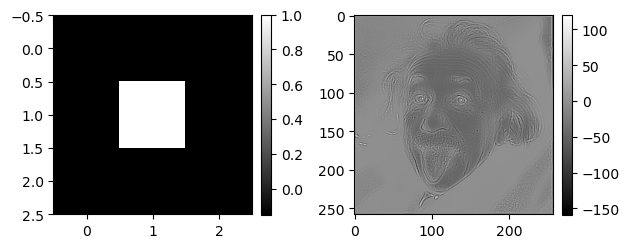

In [7]:
filter = square_filter(v = -0.15, l = 3)
plot_filter_and_image(filter, apply_filter(image, filter))

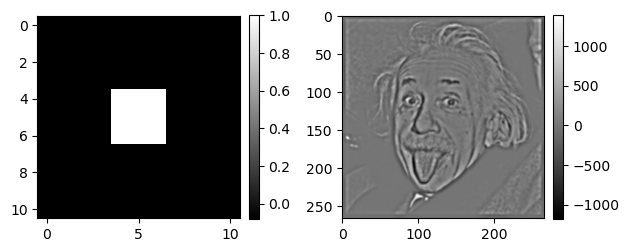

In [8]:
filter = square_filter(v = -9 / (11 * 11 - 9), l = 11)
plot_filter_and_image(filter, apply_filter(image, filter))

## (C) Difference-of-Gaussians filter

Repeat (B) using a difference-of-gaussian $K(x, y)$ as

$$
K(x, y) = \frac{w_c}{\sigma_c^2} exp(-\frac{x^2+y^2}{2\sigma_c^2}) - \frac{w_s}{\sigma_s^2} exp(-\frac{x^2+y^2}{2\sigma_s^2})
$$

Play with parameters $w_c$, $w_s$, $\sigma_c$ and $\sigma_s$ and understand how $K(x, y)$ changes with each these parameters, and thus the meaning of these parameters. Filter the original image using this $K(x, y)$ and see the outcome as the retinal ganglion cells population responses. For a retinal ganglion cell, you may try $w_c = 1.1w_s$ and $\sigma_s = 5\sigma_c$.


In [9]:
def gaussian(w_c, w_s, sigma_c, sigma_s, x, y):
    return w_c / pow(sigma_c, 2) * np.exp(-(pow(x, 2) + pow(y, 2)) / 2 * pow(sigma_c, 2)) - \
        w_s / pow(sigma_s, 2) * np.exp(-(pow(x, 2) + pow(y, 2)) / 2 * pow(sigma_s, 2))

In [10]:
def gaussian_filter(w_c, w_s, sigma_c, sigma_s, l = 101):
    filter = np.zeros(shape = (l, l))

    center = int(l / 2)

    for i in range(filter.shape[0]):
        for j in range(filter.shape[1]):
            filter[i, j] = gaussian(w_c, w_s, sigma_c, sigma_s, i - center, j - center)

    return filter

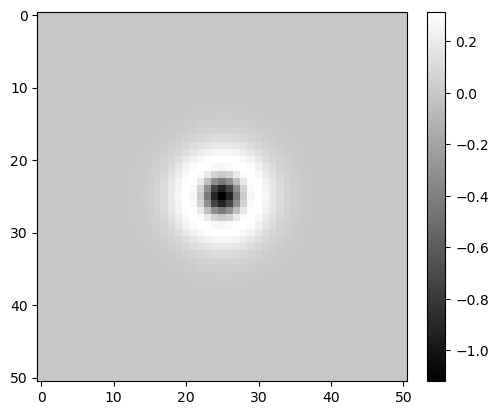

In [11]:
filter = gaussian_filter(0.055, 0.5, 0.25, 0.5, l = 51)

plt.imshow(filter, cmap = "gray")
plt.colorbar(fraction = 0.046, pad = 0.04)
plt.show()

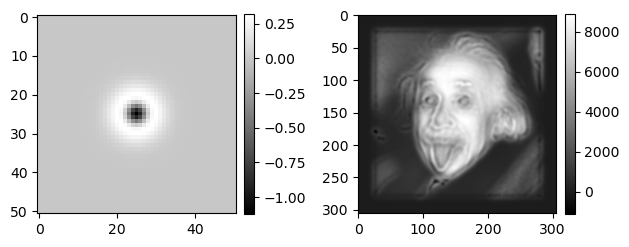

In [12]:
plot_filter_and_image(filter, apply_filter(image, filter))

## (D) Vertical orientation selective neuron

Repeat (C), but use a receptive field filter shape $K(x, y)$ that models a V1’s simple cell’s receptive field. Use an orientation selective neuron (tuning to vertical orientation), with

$$
K(x, y) = exp(-\frac{x^2}{2\sigma^2_x} - \frac{y^2}{2\sigma^2_y})cos(\bar{k}x + \phi)
$$

Vary parameters $\sigma_x$, $\sigma_y$, $\bar{k}$, and $\phi$ and plot out $K(x, y)$ using different set of parameters to see how these parameters control the shape of $K(x, y)$. For a V1 cell model, try for example $\sigma_y = 1.5\sigma_x$, and $\bar{k} = 2\pi / (3\sigma_x)$, and filter the original image using this $K(x, y)$ and see the outcome as the population responses of V1 neurons preferring this orientation.

In [13]:
def vertical_orientation(sigma_x, sigma_y, k, phi, x, y):
    return np.exp(-(pow(x, 2) / (2 * pow(sigma_x, 2))) - (pow(y, 2)) / (2 * pow(sigma_y, 2))) * np.cos(k * x + phi)

In [14]:
def vertical_filter(sigma_x, sigma_y, k, phi, l = 101):
    filter = np.zeros(shape = (l, l))

    center = int(l / 2)

    for i in range(filter.shape[0]):
        for j in range(filter.shape[1]):
            filter[i, j] = vertical_orientation(sigma_x, sigma_y, k, phi, i - center, j - center)

    return filter

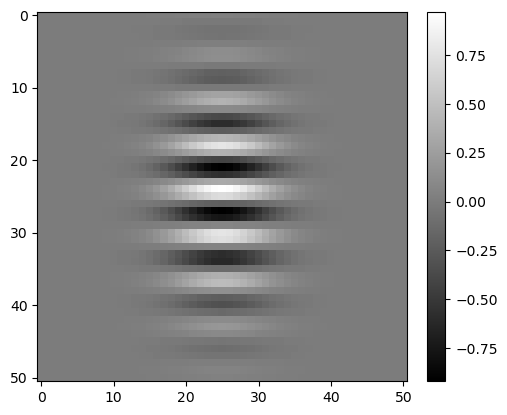

In [15]:
filter = vertical_filter(
    sigma_x = 10,
    sigma_y = 5,
    k = 1,
    phi = math.radians(45),
    l = 51
)

plt.imshow(filter, cmap = "gray")
plt.colorbar(fraction = 0.046, pad = 0.04)
plt.show()

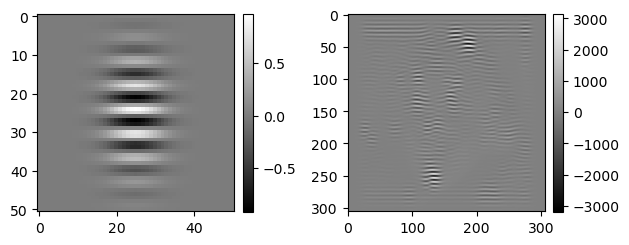

In [16]:
plot_filter_and_image(filter, apply_filter(image, filter))

## (E) Horizontal orientation selective neuron

Repeat (D), but using a $K(x, y)$ that is tune to horizontal orientation, i.e., 

$$
K(x, y) = exp(-\frac{x^2}{2\sigma^2_x} - \frac{y^2}{2\sigma^2_y})cos(\bar{k}y + \phi)
$$

Plot out $K(x, y)$ from equations 3 and 4 side by side to compare and see they how differ from each other. Plot out the neural population responses from these two filters side by side and see how they differ from each other, and comment on these differences.


In [17]:
def horizontal_orientation(sigma_x, sigma_y, k, phi, x, y):
    return np.exp(-(pow(x, 2) / (2 * pow(sigma_x, 2))) - (pow(y, 2)) / (2 * pow(sigma_y, 2))) * np.cos(k * y + phi)

In [18]:
def horizontal_filter(sigma_x, sigma_y, k, phi, l = 101):
    filter = np.zeros(shape = (l, l))

    center = int(l / 2)

    for i in range(filter.shape[0]):
        for j in range(filter.shape[1]):
            filter[i, j] = horizontal_orientation(sigma_x, sigma_y, k, phi, i - center, j - center)

    return filter

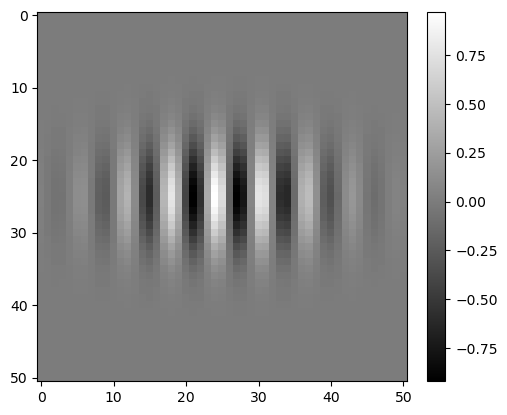

In [19]:
filter = horizontal_filter(
    sigma_x = 5,
    sigma_y = 10,
    k = 1,
    phi = math.radians(45),
    l = 51
)

plt.imshow(filter, cmap = "gray")
plt.colorbar(fraction = 0.046, pad = 0.04)
plt.show()

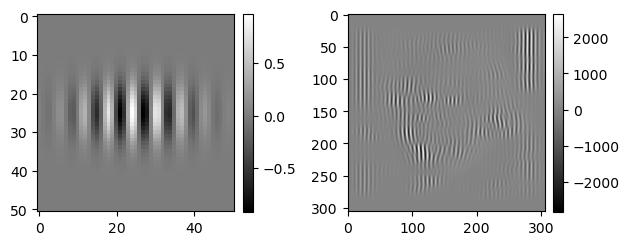

In [20]:
plot_filter_and_image(filter, apply_filter(image, filter))

## (F) Contrast sensitivity function for a retinal ganglion cell

Use the retinal ganglion cell’s $K(x, y)$ from part (C) and try to get its contrast sensitivity function $g(k)$ by calculating

$$
g_c(k) = \sum_{x,y} K(x, y) cos(kx)
$$

and

$$
g_s(k) = \sum_{x,y} K(x, y) sin(kx)
$$

Finally, calculate

$$
g(k) = \sqrt{[g_s(k)]^2 + [g_c(k)]^2}
$$

for all kinds of values of k, so that you get $g(k)$ as a function of $k$, and plot out $g(k)$ versus $k$. Do you see that $g(k)$ peaks at a particular $k$?


In [26]:
def g_center(kernel, k):
    res = 0
    center = int(kernel.shape[0] / 2)

    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            res += kernel[i, j] * np.cos(k * (i - center))

    return res

In [27]:
def g_surround(kernel, k):
    res = 0
    center = int(kernel.shape[0] / 2)

    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            res += kernel[i, j] * np.sin(k * (i - center))

    return res

In [42]:
def g(kernel, k):
    g_k = []
    for _k in k:
        g_k.append(math.sqrt(math.pow(g_surround(kernel, _k), 2) + math.pow(g_center(kernel, _k), 2)))

    return g_k

In [43]:
kernel = gaussian_filter(0.055, 0.5, 0.25, 0.5, l = 51)

k = np.array(range(40, 200)) / 20
g_k = g(kernel, k)

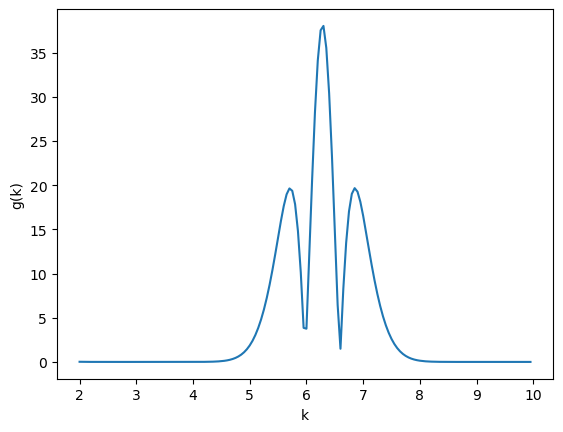

In [44]:
plt.plot(k, g_k)
plt.xlabel("k")
plt.ylabel("g(k)")
plt.show()

## (G) Contrast sensitivity function for V1 cell

Repeat part (F) with V1’s receptive field, i.e., use $K(x, y)$ in part (D), and get $g(k)$. Which $k$ value is this $g(k)$ peaking at? Is it around $k = \bar{k}$? Compare this $g(k)$ with the one you have in part (F), and see how they differ from each other.

In [45]:
kernel = vertical_filter(
    sigma_x = 10,
    sigma_y = 5,
    k = 1,
    phi = math.radians(45),
    l = 51
)

k = np.array(range(40, 200)) / 20
g_k = g(kernel, k)

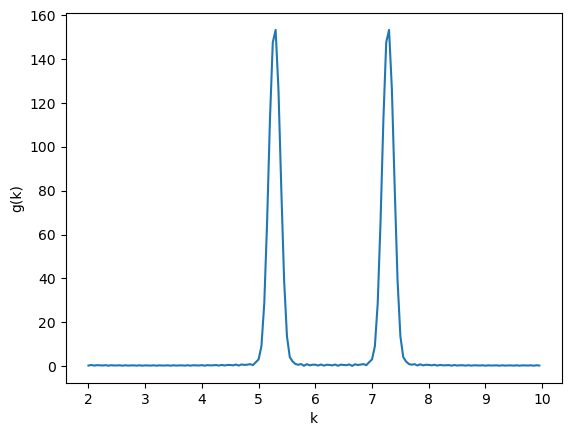

In [46]:
plt.plot(k, g_k)
plt.xlabel("k")
plt.ylabel("g(k)")
plt.show()

## (H) Power spectrum of an image

Repeat part (G) by replacing $K(x, y)$ by your own original image. Let us denote your original image as $S(x, y)$ as a function of $x$ and $y$.

$$
S_c(k) = \sum_{x,y}S(x, y)cos(kx)
$$

and

$$
S_s(k) = \sum_{x,y}S(x, y)sin(kx)
$$

From $S_c(k)$ and $S_s(k)$ calculate

$$
|S(k)|^2 = [S_c(k)]^2 + [S_s(k)]^2
$$

This $|S(k)|^2$ as a function of $k$ is called the power spectrum of an image. Plot out this function, and note a general trend of how $|S(k)|^2$ changes with $k$.


In [48]:
def power_spectrum(image, k):
    s_k = []
    for _k in k:
        s_k.append(math.pow(g_surround(image, _k), 2) + math.pow(g_center(image, _k), 2))

    return s_k

In [50]:
k = np.array(range(40, 200)) / 20
s_k = power_spectrum(np.asarray(image, dtype = "uint8"), k)

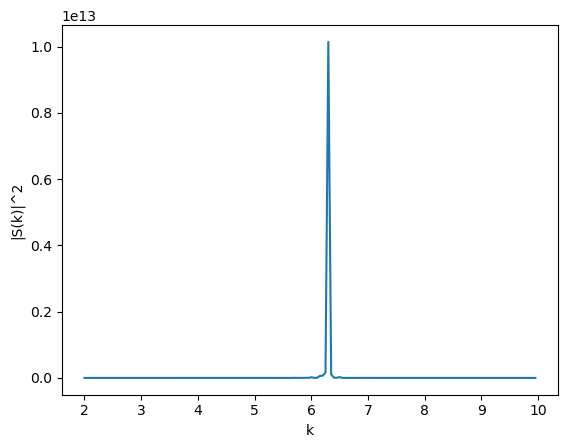

In [51]:
plt.plot(k, s_k)
plt.xlabel("k")
plt.ylabel("|S(k)|^2")
plt.show()